The RDKit's conformer generator allows you to provide distance "constraints" to bias the conformers which it produces. Last week I wondered how those constraints interact with the terms which the ETKDG algorithm adds to the "distance geometry force field".

This post uses a simple example to explore that interaction

See [another recent blog post](https://greglandrum.github.io/rdkit-blog/conformers/exploration/2021/01/31/looking-at-random-coordinate-embedding.html) for an overview of how the conformer generator works.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolTransforms
IPythonConsole.ipython_3d = True
from rdkit.Chem import Draw
import rdkit
print(rdkit.__version__)
%pylab inline

2020.09.4
Populating the interactive namespace from numpy and matplotlib


Here's the molecule we'll use:

In [2]:
m = Chem.AddHs(Chem.MolFromSmiles('OCCCCCCCN'))

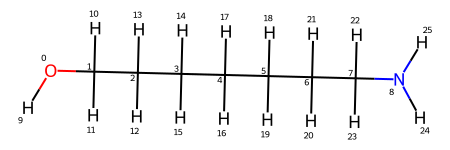

In [3]:
from rdkit.Chem import rdDepictor
m2d = Chem.Mol(m)
rdDepictor.Compute2DCoords(m2d)
IPythonConsole.drawOptions.addAtomIndices = True
m2d

Get the bounds matrix for the molecule and look at the min/max values allowed for the O-N distance:

In [4]:
bounds = rdDistGeom.GetMoleculeBoundsMatrix(m)
bounds[8,0],bounds[0,8]

(3.1500000000000004, 9.902933132591349)

Let's generate a bunch of conformers and look at the distribution of O-N distances:

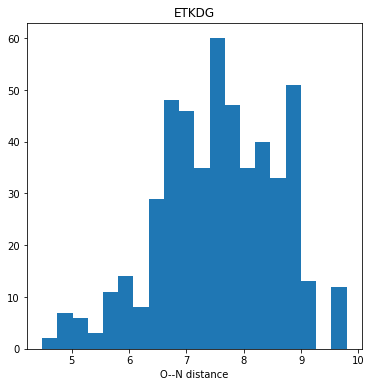

In [5]:
figsize(6,6)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
cids = rdDistGeom.EmbedMultipleConfs(m,500,ps)
dists_etkdg = [rdMolTransforms.GetBondLength(conf,0,8) for conf in m.GetConformers()]
hist(dists_etkdg,bins=20);
title('ETKDG');
xlabel('O--N distance');

Look at one conformer:

In [6]:
print(rdMolTransforms.GetBondLength(m.GetConformer(cids[0]),0,8) )
IPythonConsole.drawMol3D(m,confId=cids[1])

5.989729201561945


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Compare the distribution we get doing plain DG:

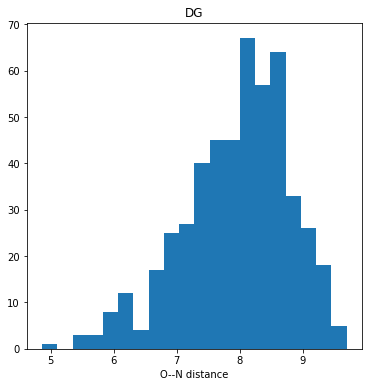

In [7]:
figsize(6,6)
ps = rdDistGeom.EmbedParameters()
ps.useExpTorsionAnglePrefs = False
ps.useBasicKnowledge = False
ps.randomSeed = 0xf00d
cids = rdDistGeom.EmbedMultipleConfs(m,500,ps)
dists = [rdMolTransforms.GetBondLength(conf,0,8) for conf in m.GetConformers()]
hist(dists,bins=20);
title('DG');
xlabel('O--N distance');

There's not a giant difference, but it does look like the DG conformers for this molecule tend to be more extended: the O and N tend to be farther away from each other.

Here's how we can modify the bounds matrix to bring the O and N closer together:

In [8]:
bounds[0,8] = 4.1
bounds[8,0] = 4.0
from rdkit import DistanceGeometry
DistanceGeometry.DoTriangleSmoothing(bounds)

True

Start with using this bounds matrix together with plain DG:

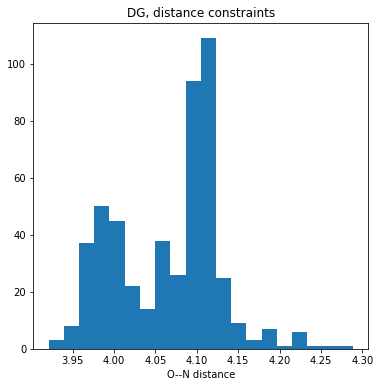

In [9]:
figsize(6,6)
ps = rdDistGeom.EmbedParameters()
ps.useExpTorsionAnglePrefs = False
ps.useBasicKnowledge = False
ps.randomSeed = 0xf00d
ps.SetBoundsMat(bounds)
cids = rdDistGeom.EmbedMultipleConfs(m,500,ps)
dists = [rdMolTransforms.GetBondLength(conf,0,8) for conf in m.GetConformers()]
hist(dists,bins=20);
title('DG, distance constraints');
xlabel('O--N distance');

In [10]:
print(rdMolTransforms.GetBondLength(m.GetConformer(cids[0]),0,8) )
IPythonConsole.drawMol3D(m,confId=cids[0])

3.9739942608788374


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

When we do ETKDG we add additional terms to the force field that's used to optimize the structure. Do these override our distance constraints?

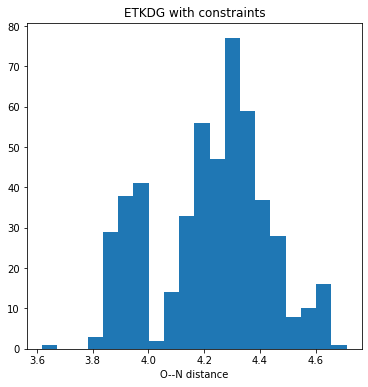

In [11]:
figsize(6,6)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.SetBoundsMat(bounds)
cids = rdDistGeom.EmbedMultipleConfs(m,500,ps)
dists = [rdMolTransforms.GetBondLength(conf,0,8) for conf in m.GetConformers()]
hist(dists,bins=20);
title('ETKDG with constraints');
xlabel('O--N distance');

Most of the distances are longer than what we were looking for, but they are still considerably shorter than what we saw before:

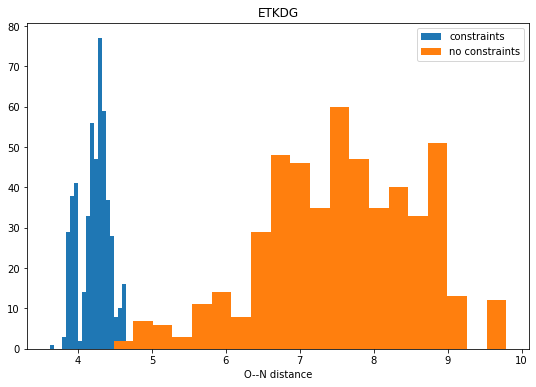

In [12]:
figsize(9,6)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.SetBoundsMat(bounds)
cids = rdDistGeom.EmbedMultipleConfs(m,500,ps)
dists = [rdMolTransforms.GetBondLength(conf,0,8) for conf in m.GetConformers()]
hist(dists,bins=20,label='constraints');
title('ETKDG');
hist(dists_etkdg,bins=20,label='no constraints');
legend();
xlabel('O--N distance');

So that answers our original question: the "constraints" we place on the conformers by modifying the bounds matrix aren't strict, so the additional terms added by ETKDG can result in them being violated. But the results are still significant biased towards the region of conformer space we wanted to explore.

Let's try forcing conformations which have distances consistent with an intra-molecular hydrogen bond. Here we need to modify the bounds matrix elements between both the O and the N as well as the O and one of the Hs attached to the N. If we don't adjust the O-N distance bounds too we end up with a bounds matrix which cannot be smoothed.

In [13]:
bounds = rdDistGeom.GetMoleculeBoundsMatrix(m)
bounds[0,25] = 1.9
bounds[25,0] = 1.8
bounds[0,8] = 3.2
bounds[8,0] = 2.9
from rdkit import DistanceGeometry
DistanceGeometry.DoTriangleSmoothing(bounds)

True

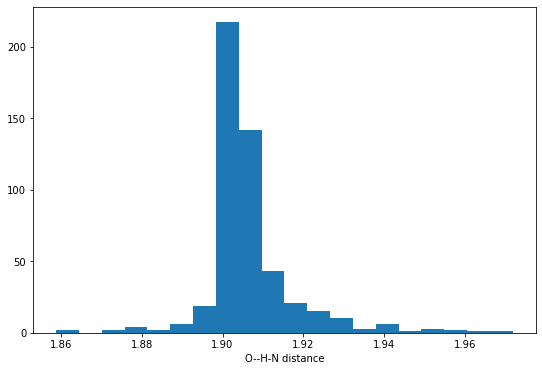

In [14]:
figsize(9,6)

ps = rdDistGeom.EmbedParameters()
ps.useExpTorsionAnglePrefs = False
ps.useBasicKnowledge = False
ps.randomSeed = 0xf00d
ps.SetBoundsMat(bounds)
cids = rdDistGeom.EmbedMultipleConfs(m,500,ps)
dists = [rdMolTransforms.GetBondLength(conf,0,25) for conf in m.GetConformers()]
hist(dists,bins=20);
xlabel('O--H-N distance');

In [15]:
print(rdMolTransforms.GetBondLength(m.GetConformer(cids[0]),0,25) )
IPythonConsole.drawMol3D(m,confId=cids[0])

1.9045497511922502


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Try using ETKDG:

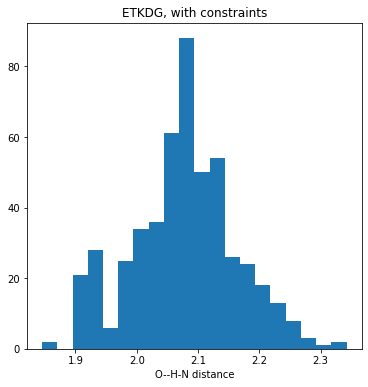

In [16]:
figsize(6,6)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.SetBoundsMat(bounds)
cids = rdDistGeom.EmbedMultipleConfs(m,500,ps)
dists = [rdMolTransforms.GetBondLength(conf,0,25) for conf in m.GetConformers()]
hist(dists,bins=20);
title('ETKDG, with constraints');
xlabel('O--H-N distance');

In [17]:
print(rdMolTransforms.GetBondLength(m.GetConformer(cids[0]),0,25) )
IPythonConsole.drawMol3D(m,confId=cids[0])

2.0641816694294173


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The O--H-N distances here aren't completely obeying the 1.8-1.9 distance bounds we imposed, but they seem to match a bit better than what we saw above when we constrained the O--N distance. I think that's likely because now we have an additional constraining term - the O--H distance as well as the O--N distance - to help override the ETKDG preferences.

So to repeat the conclusion: modifying the distance bounds matrix doesn't act as a hard constraint when we include ETKDG terms in the conformer generation process, but it definitely biases the results towards the areas of conformer space which we were trying to access.